In [1]:
import os, glob
from scipy.io import wavfile
#import pandas as pd
import re
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
import math

rate = 48000

basepath = "toyset"

cleanpath_train = os.path.join(os.path.join(".", basepath), "train_clean")
noisypath_train = os.path.join(os.path.join(".", basepath), "train_noisy")
cleanpath_test = os.path.join(os.path.join(".", basepath), "test_clean")
noisypath_test = os.path.join(os.path.join(".", basepath), "test_noisy")

x_train = list()
y_train = list()
x_test = list()
y_test = list()

w_length = 100
w_shift  = 50

def make_windows_x(data, window_lenght = w_length, step = w_shift):
    start_sample = 0
    end_sample = start_sample + window_lenght
    windows = list()
    while end_sample < len(data)+1:
        windows.append(data[start_sample:end_sample])
        start_sample += step
        end_sample = start_sample + window_lenght
    return windows

def make_windows_y(data, window_lenght = w_shift, step = w_shift):
     start_sample = round (w_length/2 - w_shift/2)   
     end_sample = start_sample + window_lenght
     windows = list()
     while end_sample < len(data)+1 - round (w_length/2 - w_shift/2) : 
        windows.append(data[start_sample:end_sample])
        start_sample += step
        end_sample = start_sample + window_lenght
     return windows

def loading_data_x(path, index):
    for file in os.listdir(path):
        if file.endswith(".wav"):
            rate, data = wavfile.read(os.path.join(path, file))
            ws = make_windows_x(data)
            for item in ws:
                index.append(item)
                
def loading_data_y(path, index):
    for file in os.listdir(path):
        if file.endswith(".wav"):
            rate, data = wavfile.read(os.path.join(path, file))
            ws = make_windows_y(data)
            for item in ws:
                index.append(item)
                

In [2]:
loading_data_y(cleanpath_train, y_train)
print("Length of training Y: {} windows".format(len(y_train)))

Length of training Y: 111188 windows


In [3]:
loading_data_x(noisypath_train, x_train)
print("Length of training X: {} windows".format(len(x_train)))

Length of training X: 111188 windows


In [4]:
loading_data_x(noisypath_test, x_test)
print("Length of test X: {} windows".format(len(x_test)))

Length of test X: 29850 windows


In [5]:
loading_data_y(cleanpath_test, y_test)
print("Length of test Y: {} windows".format(len(y_test)))


Length of test Y: 29850 windows


In [7]:
max_const = 32767

x_train = np.array(x_train).astype(float)
y_train = np.array(y_train).astype(float)
x_train /= max_const # simple normalization
y_train /= max_const
print(x_train.shape)
print(y_train.shape)

(111188, 100)
(111188, 50)


In [8]:
x_test = np.array(x_test).astype(float)
y_test = np.array(y_test).astype(float)
x_test /= max_const
y_test /= max_const
print(x_test.shape)
print(y_test.shape)

(29850, 100)
(29850, 50)


In [9]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras.backend as K
from keras.callbacks.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = Sequential()
model.add(Dense(200, input_shape=(w_length,)))

model.add(Dense(200, activation='relu'))

model.add(Dense(200, activation='relu'))

model.add(Dense(200, activation='relu'))

model.add(Dense(w_shift, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])

#earlystopping = EarlyStopping(monitor='val_loss', patience=5)
network_history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), shuffle=True) 

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 111188 samples, validate on 29850 samples
Epoch 1/5
111188/111188 [==============================] - 15s 133us/step - loss: 8.1229e-04 - rmse: 0.0279 - val_loss: 9.1787e-04 - val_rmse: 0.0254
Epoch 2/5
111188/111188 [==============================] - 14s 129us/step - loss: 6.6379e-04 - rmse: 0.0253 - val_loss: 7.3303e-04 - val_rmse: 0.0226
Epoch 3/5
111188/111188 [==============================] - 14s 129us/step - loss: 6.2992e-04 - rmse: 0.0247 - val_loss: 7.2559e-04 - val_rmse: 0.0226
Epoch 4/5
111188/111188 [==============================] - 14s 128us/step - loss: 6.0165e-04 - rmse: 0.0241 - val_loss: 6.9743e-04 - val_rmse: 0.0219
Epoch 5/5
111188/111188 [==============================] - 14s 129us/step - loss: 5.8898e-04 - rmse: 0.0238 - val_loss: 6.5592e-04 - val_rmse: 0.0212


In [10]:
model.evaluate(x_test, y_test, batch_size = 32)

29850/29850 [==============================] - 1s 35us/step


[0.0006559238821692257, 0.021241294220089912]

In [11]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('rmse')
    plt.plot(network_history.history['rmse'])
    plt.plot(network_history.history['val_rmse'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


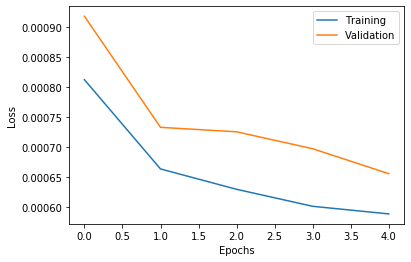

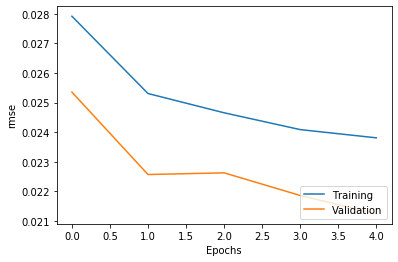

In [12]:
plot_history(network_history)

In [13]:
output = model.predict(x_test, batch_size=32)

In [45]:
#output.shape

In [46]:
#output


In [14]:
output *= max_const

In [48]:
#output

In [15]:
output = output.reshape(-1)

In [16]:
#output

In [74]:
output = np.array(output).astype(np.int16)
#output

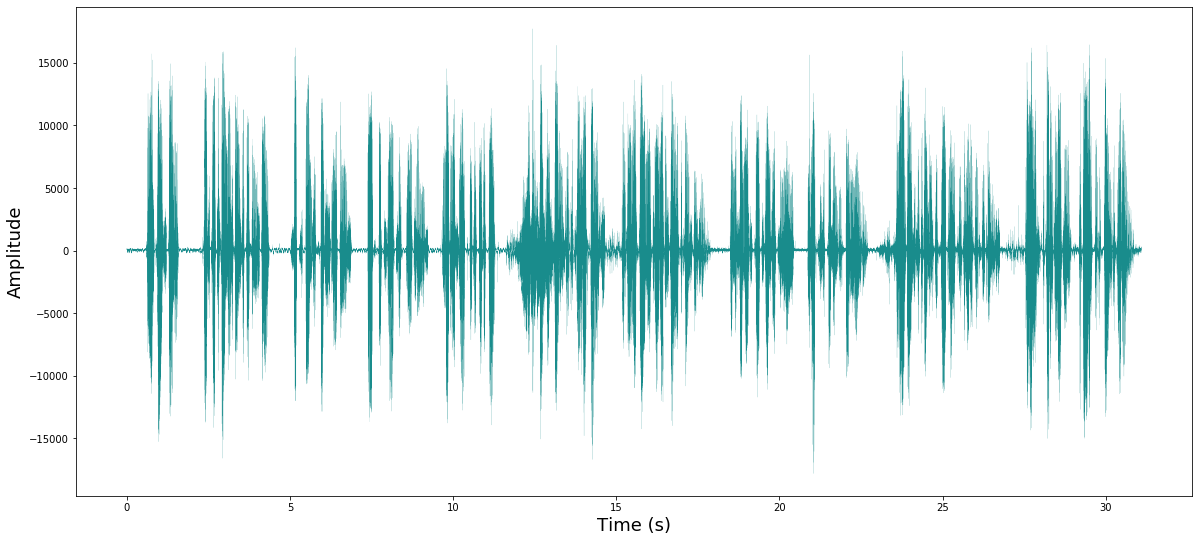

In [75]:
rate = 48000
time = np.arange(0, float(output.shape[0]), 1) / rate
plt.figure(1, figsize=(20,9))
plt.subplot(111)
plt.plot(time, output, linewidth=0.1, alpha=0.9, color='teal') #
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.show()

In [76]:
scipy.io.wavfile.write('output_generate.wav', rate, output)

In [54]:
#x_test


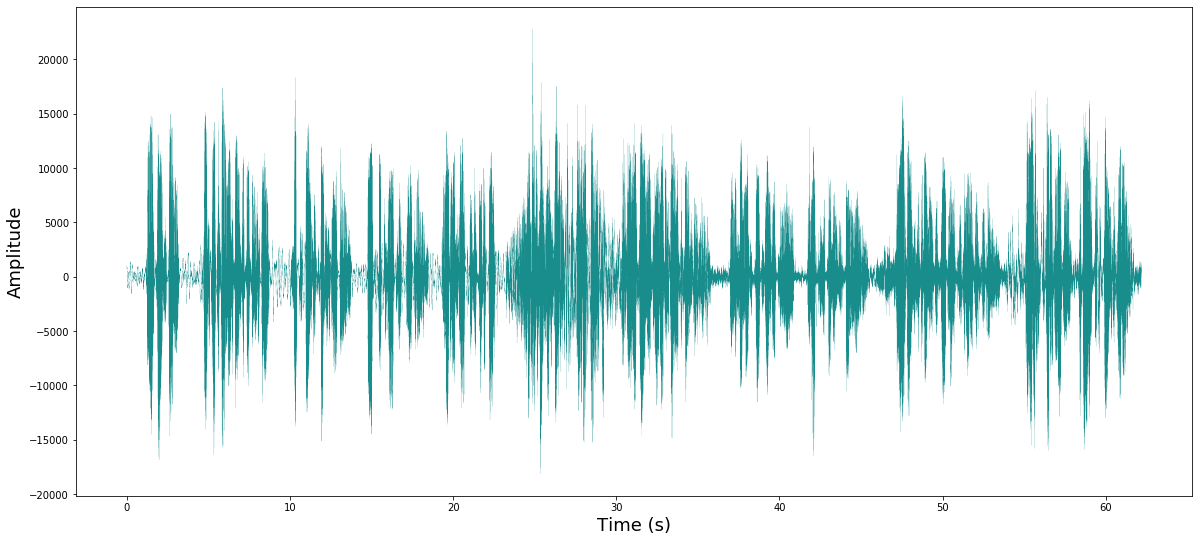

In [19]:
#zaj csökken de a beszéd minősége is romlik

insignal = x_test
insignal *= max_const
insignal = insignal.reshape(-1)
insignal = np.array(insignal).astype(np.int16)

rate = 48000
time = np.arange(0, float(insignal.shape[0]), 1) / rate
plt.figure(1, figsize=(20,9))
plt.subplot(111)
plt.plot(time, insignal, linewidth=0.1, alpha=0.9, color='teal') #
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.show()

scipy.io.wavfile.write('insignal7.wav', rate, insignal)



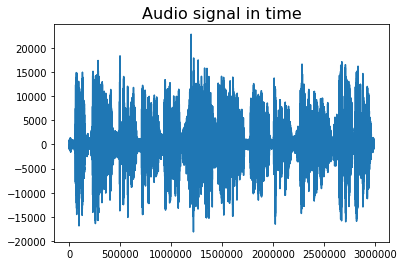

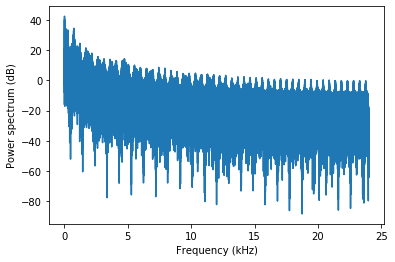

In [20]:
Audiodata = insignal
fs = 48000
# Plot the audio signal in time
import matplotlib.pyplot as plt
plt.plot(Audiodata)
plt.title('Audio signal in time',size=16)

# spectrum
from scipy.fftpack import fft # fourier transform
n = len(Audiodata) 
AudioFreq = fft(Audiodata)
AudioFreq = AudioFreq[0:int(np.ceil((n+1)/2.0))] #Half of the spectrum
MagFreq = np.abs(AudioFreq) # Magnitude
MagFreq = MagFreq / float(n)
# power spectrum
MagFreq = MagFreq**2
if n % 2 > 0: # ffte odd 
    MagFreq[1:len(MagFreq)] = MagFreq[1:len(MagFreq)] * 2
else:# fft even
    MagFreq[1:len(MagFreq) -1] = MagFreq[1:len(MagFreq) - 1] * 2 

plt.figure()
freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq)) #Power spectrum
plt.xlabel('Frequency (kHz)'); plt.ylabel('Power spectrum (dB)');

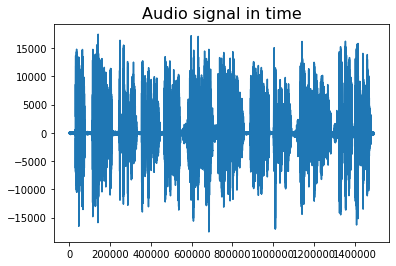

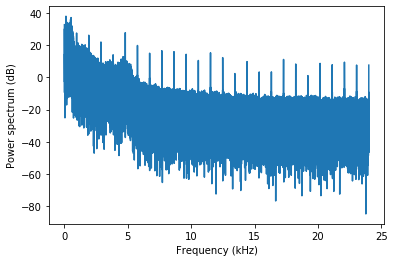

In [21]:
Audiodata = output

# Plot the audio signal in time
import matplotlib.pyplot as plt
plt.plot(Audiodata)
plt.title('Audio signal in time',size=16)

# spectrum
from scipy.fftpack import fft # fourier transform
n = len(Audiodata) 
AudioFreq = fft(Audiodata)
AudioFreq = AudioFreq[0:int(np.ceil((n+1)/2.0))] #Half of the spectrum
MagFreq = np.abs(AudioFreq) # Magnitude
MagFreq = MagFreq / float(n)
# power spectrum
MagFreq = MagFreq**2
if n % 2 > 0: # ffte odd 
    MagFreq[1:len(MagFreq)] = MagFreq[1:len(MagFreq)] * 2
else:# fft even
    MagFreq[1:len(MagFreq) -1] = MagFreq[1:len(MagFreq) - 1] * 2 

plt.figure()
freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq)) #Power spectrum
plt.xlabel('Frequency (kHz)'); plt.ylabel('Power spectrum (dB)');